In [2]:
import deepxde as dde
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from tqdm import tqdm
import struct
import matplotlib.cm as cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import os
from enum import Enum
from functools import partial
import sys

data_kind = {1:"apartment_multi", 2:"apartment_room"}
value_kind = {1: "CARBON MONOXIDE", 2: "CARBON DIOXIDE", 3: "OXYGEN", 4: "TEMPERATURE", 5:"VELOCITY"}

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


# Data Processing

## Simulation Data

### Data Saved

1  CARBON MONOXIDE VOLUME FRACTION

2  CARBON DIOXIDE VOLUME FRACTION
 
3  OXYGEN VOLUME FRACTION

4  TEMPERATURE

5  VELOCITY

6  U-VELOCITY

7  V-VELOCITY

8  W-VELOCITY

In [3]:
def slread( fname, Tstart, Tend, *args, **kwargs ):

    """
    Reads FDS 3D slice file
    Based on slread.py and sl3d_read.m by Randy McDermott
    https://github.com/firemodels/fds/blob/master/Utilities/Matlab/scripts/slread.m
    https://github.com/firemodels/fds/blob/master/Utilities/Matlab/scripts/sl3d_read.m
    (QQ,Time)=slread(fname,Tstart,Tend [,Nframes, gridskip, timeskip]);
      Tstart  is start time
      Tend    is end time
      Nframes is number of slice file frames (FDS default is 1000 between Tstart and Tend)
      gridskip is a skip rate for reading cells: =2 --> read every other cell, etc.
      timeskip is a skip rate for frames: =2 --> read every other frame, etc.
      QQ      contains the data
      Time    contains the time points
    """

    print(fname, flush=True)
    print(Tstart, flush=True)
    print(Tend, flush=True)

    if len(args)==0:
        Nframes = 1000
    else:
        Nframes = args[0]
        
    gridskip = kwargs['gridskip'] if 'gridskip' in kwargs else 1
    timeskip = kwargs['timeskip'] if 'timeskip' in kwargs else 1
        
    f = open(fname,'rb')

    f.read(4)
    Str1 = f.read(30)       # quantity
    print(Str1, flush=True)
    f.read(8)
    Str2 = f.read(30)       # short name
    print(Str2, flush=True)
    f.read(8)
    Str3 = f.read(30)       # units
    print(Str3, flush=True)
    f.read(8)
    Indx = struct.unpack('6i',f.read(24))  # index bounds i,j,k
    print(Indx, flush=True)
    f.read(4)

    # allocate arrays for QQ and Time

    Isize = Indx[1]-Indx[0]+1
    Jsize = Indx[3]-Indx[2]+1
    Ksize = Indx[5]-Indx[4]+1
    
    Nframes = max(1,Nframes)
    QQ = np.zeros([Isize,Jsize,Ksize])
    Time = np.zeros(Nframes+1)
    
    ii = np.arange(0,Isize,gridskip)
    jj = np.arange(0,Jsize,gridskip)
    kk = np.arange(0,Ksize,gridskip)
    tt = np.arange(0,Nframes+1,timeskip)
    Qskip  = np.zeros((len(ii),len(jj),len(kk),len(tt)))

    st = 0

    while Time[st] < Tstart:

        f.read(4)
        Time_list = struct.unpack('f',f.read(4))
        
        Time[st] = Time_list[0]

        f.read(8)
        for id_k in range(Ksize):
            for id_j in range(Jsize):
                for id_i in range(Isize):
                    QQ_list = struct.unpack('f',f.read(4))
                    QQ[id_i,id_j,id_k] = QQ_list[0]
        f.read(4)

    while Time[st] < Tend:

        f.read(4)
        eof_check = f.read(4)
        if not eof_check:
            # eof
            break
        Time_list = struct.unpack('f',eof_check)
        # print(Time_list)
        Time[st] = Time_list[0]
        f.read(8)
        for id_k in range(Ksize):
            for id_j in range(Jsize):
                for id_i in range(Isize):
                    QQ_list = struct.unpack('f',f.read(4))
                    QQ[id_i,id_j,id_k] = QQ_list[0]
        if st%timeskip==0:
            # print(st,int(st/timeskip))
            Qskip[:,:,:,int(st/timeskip)] = QQ[np.ix_(ii,jj,kk)]
        f.read(4)
        st = st + 1
        if st>Nframes:
            break


    return(Qskip,Time[tt])


In [4]:
class Particle(Enum):
    CO2 = 1
    CO = 2
    O2 = 3
    TEMP = 4
    VEL = 5
    VEL_X = 6
    VEL_Y = 7
    VEL_Z = 8

class Place(Enum):
    MULTI = 1
    ROOM = 2

data_kind = {1:"apartment_multi", 2:"apartment_room"}
route_kind = {1: "Apartment_place2", 2: "Apartment_multi_case"}
value_kind = {1: "CARBON MONOXIDE", 2: "CARBON DIOXIDE", 3: "OXYGEN", 4: "TEMPERATURE", 5:"VELOCITY", 6:"VELOCITY_X", 7:"VELOCITY_Y", 8:"VELOCITY_Z"}

In [5]:
def get_meshs_data(data_kind_idx, value_kind_idx):
    datas = []
    times = []
    MAX_MESH = 5
    for meshIDX in range(1, MAX_MESH + 1):
        print("meshIDX: ", meshIDX, flush=True)
        sf_file_name = "./{}/{}_{}_{}.sf".format(data_kind[data_kind_idx], route_kind[data_kind_idx], meshIDX, value_kind_idx)

        temp, time = slread(sf_file_name, 0, 300, 9000)

        last_idx = time.argmax()

        datas.append(temp[:, :, :, :last_idx+1])
        times.append(time[:last_idx+1])
    
    return datas, times

In [6]:
def mesh_sorting(temp_data):
    
    MAX_MESH = 5
    for i in range(MAX_MESH):
        # temp_data[i] = np.flip(temp_data[i], axis=1)
        print("temp_data[",i,"].shape: ", temp_data[i].shape, flush=True)

    temp_data[0] = np.concatenate((temp_data[0], temp_data[1]), axis=0)
    print("temp_data[0].shape: ", temp_data[0].shape, flush=True)
    
    temp_data[1] = None
    
    temp_data[2] = np.concatenate((temp_data[2], temp_data[4], temp_data[3]), axis=0)
    print("temp_data[2].shape: ", temp_data[2].shape, flush=True)
    
    temp_data[3] = None
    temp_data[4] = None
    
    temp_data[2] = np.delete(temp_data[2], temp_data[0].shape[0], axis=0)
    print("temp_data[2].shape: ", temp_data[2].shape, flush=True)
    
    data = np.concatenate((temp_data[2], temp_data[0]), axis=1)
    print("data.shape: ", data.shape, flush=True)
    
    temp_data[0] = None
    temp_data[2] = None
    temp_data = None

    return data

In [19]:
def get_data(data_kind_idx, value_kind_idx):

    print("data_kind_idx: "+ str(data_kind_idx)+", value_kind_idx: " + str(value_kind_idx), flush=True)
    sys.stdout.flush()
    temp_data, temp_time = get_meshs_data(data_kind_idx, value_kind_idx)
    sys.stdout.flush()
    data = mesh_sorting(temp_data.copy())
    sys.stdout.flush()
    np.save(data_kind[data_kind_idx]+"_"+value_kind[value_kind_idx], data)
    np.save(data_kind[data_kind_idx]+"_time", temp_time[0])
    print("data saved", flush=True)
    sys.stdout.flush()
    return data, temp_time[0]

In [8]:
def get_data_kinds(Place):
    data_kinds = []
    for p in Place:
        data_kinds.append(p.value)
    return data_kinds

def get_value_kinds(Particle):
    value_kinds = []
    for p in Particle:
        value_kinds.append(p.value)
    return value_kinds

def multi_kind_get_data(Particle):
    return get_data(Place.MULTI.value, Particle)

def all_get_data():
    for p in Particle:
        print("Particle: ", p, flush=True)
        get_data(Place.MULTI.value, p.value)   

    for p in Particle:
        print("Particle: ", p, flush=True)
        get_data(Place.ROOM.value, p.value)

In [9]:
# 데이터 크기가 커 저장하한후 처리함
# all_get_data()

In [23]:
def data_load(data_kind_idx, value_kind_idx):
    data = np.load(data_kind[data_kind_idx]+"_"+value_kind[value_kind_idx]+".npy")
    time = np.load("time.npy")
    return data, time

## Visualazation

In [26]:
# 각 축을 기준으로 슬라이스를 시각화하는 함수
def visualize_slices_space(data, time, times, title='null', isSave=False, iSVisual=True, cmap='binary'):
    data = np.rot90(data, 1, axes=(0, 2))
    if(time > 360):
        print("360아래로 작성")
    data_idx = int(time*(len(times))/times[-1]) 
    print(data_idx)
    if(data_idx >= len(times)):
        print("data_idx가 data.shape[0]보다 큽니다.")
        return

    fig, axes = plt.subplots(6, 10, figsize=(20, 10))
    print(data.shape)
    slice_indicesYZ = np.linspace(0, data[:, :, :, data_idx].shape[0] - 1, 10).astype(int)
    slice_indicesXZ = np.linspace(0, data[:, :, :, data_idx].shape[1] - 1, 10).astype(int)
    slice_indicesXY = np.linspace(0, data[:, :, :, data_idx].shape[2] - 1, 10).astype(int)
    
    print("slice_indicesYZ: ", slice_indicesYZ)
    print("slice_indicesXZ: ", slice_indicesXY)
    print("slice_indicesXY: ", slice_indicesXZ)
    
    data = data[:, :, :, data_idx]
    
    vmax = data.max()
    vmin = data.min()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    colormapping = cm.ScalarMappable(norm=norm, cmap=cmap)

    # colormapping = cm.ScalarMappable(cmap=cmap)    
    
    for i, idx in enumerate(slice_indicesXZ):
        
        # YZ 평면 (idx 번째 슬라이스)
        ax = axes[0, i]
        ax.imshow(data[slice_indicesYZ[i], :, :], cmap=cmap, norm=norm)
        ax.set_title(f'XY Slice {slice_indicesYZ[i]}')
        ax.axis('off')

        # XY 평면 (idx 번째 슬라이스)
        ax = axes[1, i]
        ax.imshow(data[:, idx, :], cmap=cmap, norm=norm)
        ax.set_title(f'XZ Slice {idx}')
        ax.axis('off')

        # XZ 평면 (idx 번째 슬라이스)
        ax = axes[2, i]
        ax.imshow(data[:, :, slice_indicesXY[i]], cmap=cmap, norm=norm)
        ax.set_title(f'YZ Slice {slice_indicesXY[i]}')
        ax.axis('off')

        
        # XY 평면 총합
        ax = axes[3, i]
        ax.imshow(data[:, :, :].max(axis=0), cmap=cmap, norm=norm)
        ax.set_title(f'XY Slice Max')
        ax.axis('off')

        # XZ 평면 총합
        ax = axes[4, i]
        ax.imshow(data[:, :, :].max(axis=1), cmap=cmap, norm=norm)
        ax.set_title(f'XZ Slice Max')
        ax.axis('off')

        # YZ 평면 총합
        ax = axes[5, i]
        ax.imshow(data[:, :, :].max(axis=2), cmap=cmap, norm=norm)
        ax.set_title(f'YZ Slice Max')
        ax.axis('off')
    
    plt.tight_layout()
    fig.suptitle(title)
    cbar = fig.colorbar(colormapping, ax=axes, orientation='vertical')#, fraction=0.025, pad=0.04)
    
    if isSave:
        plt.savefig("./fig/apartment_"+title.split("_")[1]+"/"+title+'png')

    if iSVisual:
        plt.show()

In [27]:
# 각 축을 기준으로 슬라이스를 시각화하는 함수
def visualize_slices_time(data, times, start=0, end=300, title='null', isSave=False, iSVisual=True, cmap='binary'):
    data = np.rot90(data, 1, axes=(0, 2))
    
    fig, axes = plt.subplots(3, int(len(times)/100), figsize=(20, 10))
    print(data.shape)
    
    
    vmax = data.max()
    vmin = data.min()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    colormapping = cm.ScalarMappable(norm=norm, cmap=cmap)

    # colormapping = cm.ScalarMappable(cmap=cmap)    
    print(int(len(times)))
    
    for i, time in zip(range(0, int(len(times)/100)), range(0, int(len(times)), 100)):       

        # XY 평면 총합
        ax = axes[0, i]
        temp = data[:, :, :, time]

        ax.imshow(temp.max(axis=0), cmap=cmap, norm=norm)
        ax.set_title(f'XY {int(times[time])}s')
        ax.axis('off')

        # XZ 평면 총합
        ax = axes[1, i]
        ax.imshow(temp.max(axis=1), cmap=cmap, norm=norm)
        ax.set_title(f'XZ {int(times[time])}s')
        ax.axis('off')

        # YZ 평면 총합
        ax = axes[2, i]
        ax.imshow(temp.max(axis=2), cmap=cmap, norm=norm)
        ax.set_title(f'YZ {int(times[time])}s')
        ax.axis('off')
    
    plt.tight_layout()
    fig.suptitle(title)
    cbar = fig.colorbar(colormapping, ax=axes, orientation='vertical')#, fraction=0.025, pad=0.04)
    
    if isSave:
        plt.savefig("./fig/apartment_"+title.split("_")[1]+"/"+title+'png')

    if iSVisual:
        plt.show()

In [13]:
# 3차원 배열의 인덱스를 구함
def visual_3d(data, threshold=0.0):
    x, y, z = np.indices(data[:, :, :, 1500].shape)

    # 3차원 배열의 값을 포인트로 시각화
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x[data[:, :, :, 1500] > threshold], y[data[:, :, :, 1500] > threshold], z[data[:, :, :, 1500] > threshold], c=data[:, :, :, 1500][data[:, :, :, 1500] > threshold], s=1, cmap='binary', alpha=0.01)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()

In [14]:
# visual_3d(data)
# visualize_slices_space(data, 299.9, temp_time[0], title="sample", cmap='binary')
# visualize_slices_time(data, temp_time[0], title="sample", cmap='binary')

### Data Load

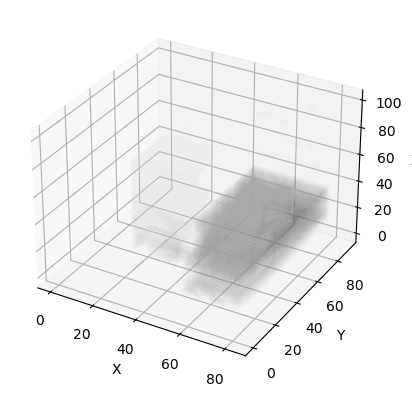

1500
(101, 93, 84, 1501)
slice_indicesYZ:  [  0  11  22  33  44  55  66  77  88 100]
slice_indicesXZ:  [ 0  9 18 27 36 46 55 64 73 83]
slice_indicesXY:  [ 0 10 20 30 40 51 61 71 81 92]


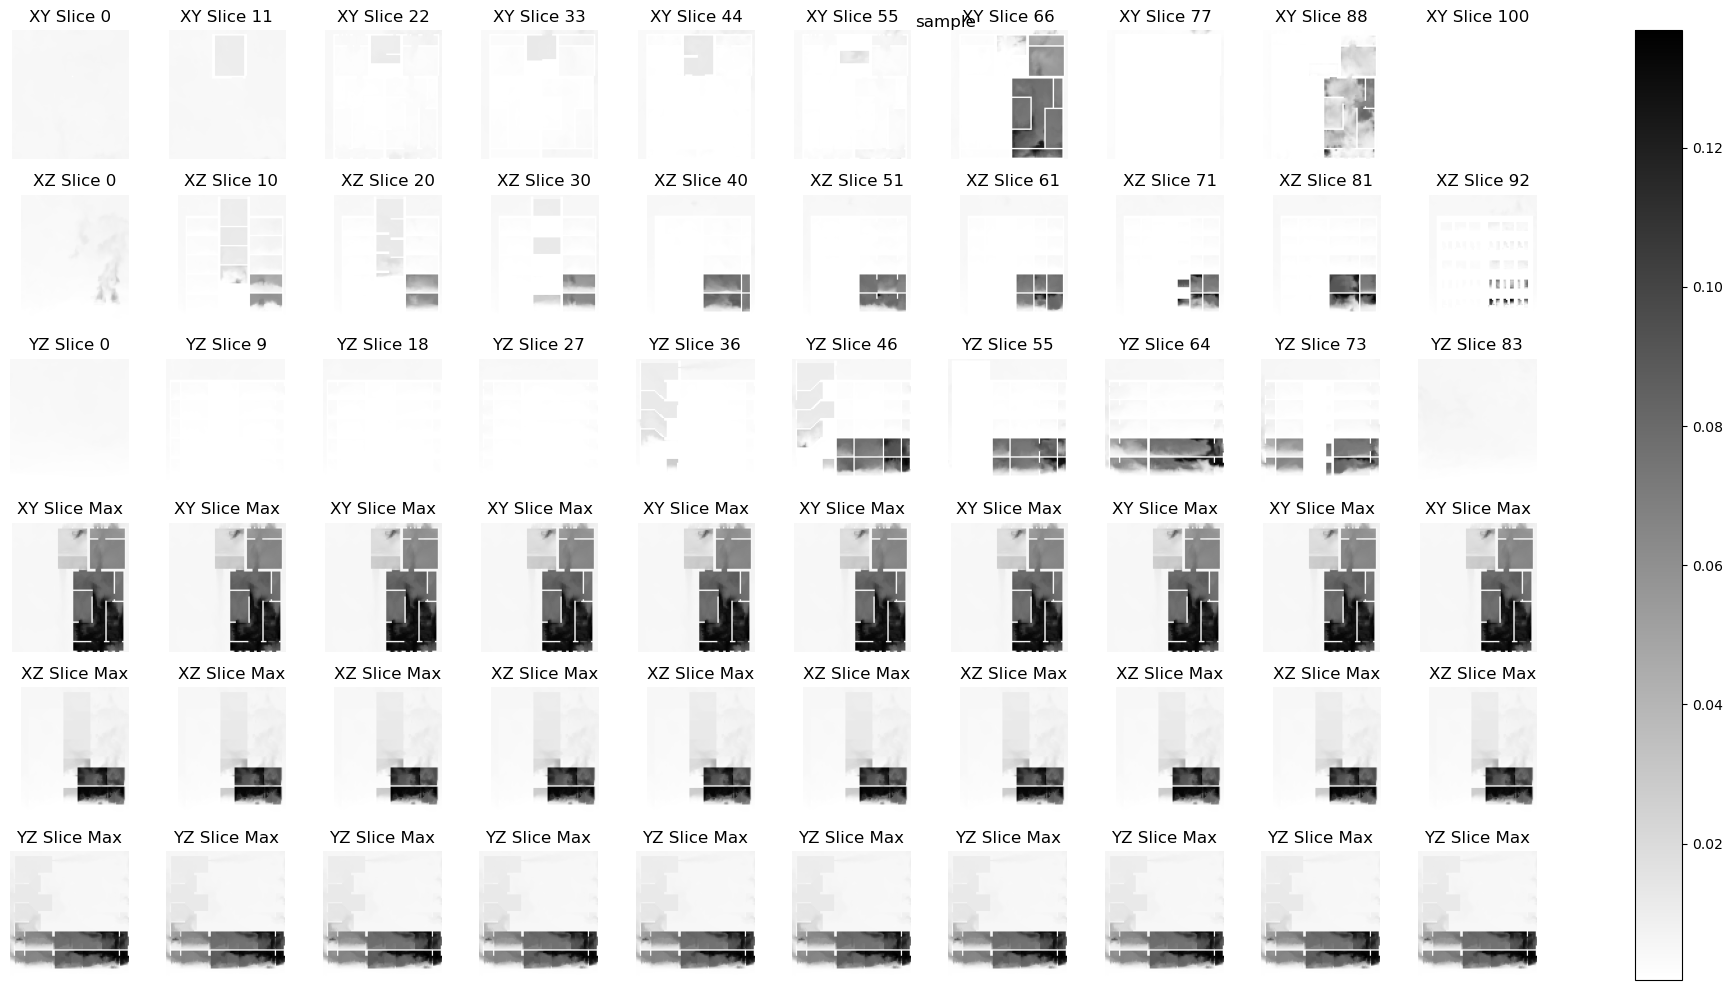

(101, 93, 84, 1501)
1501


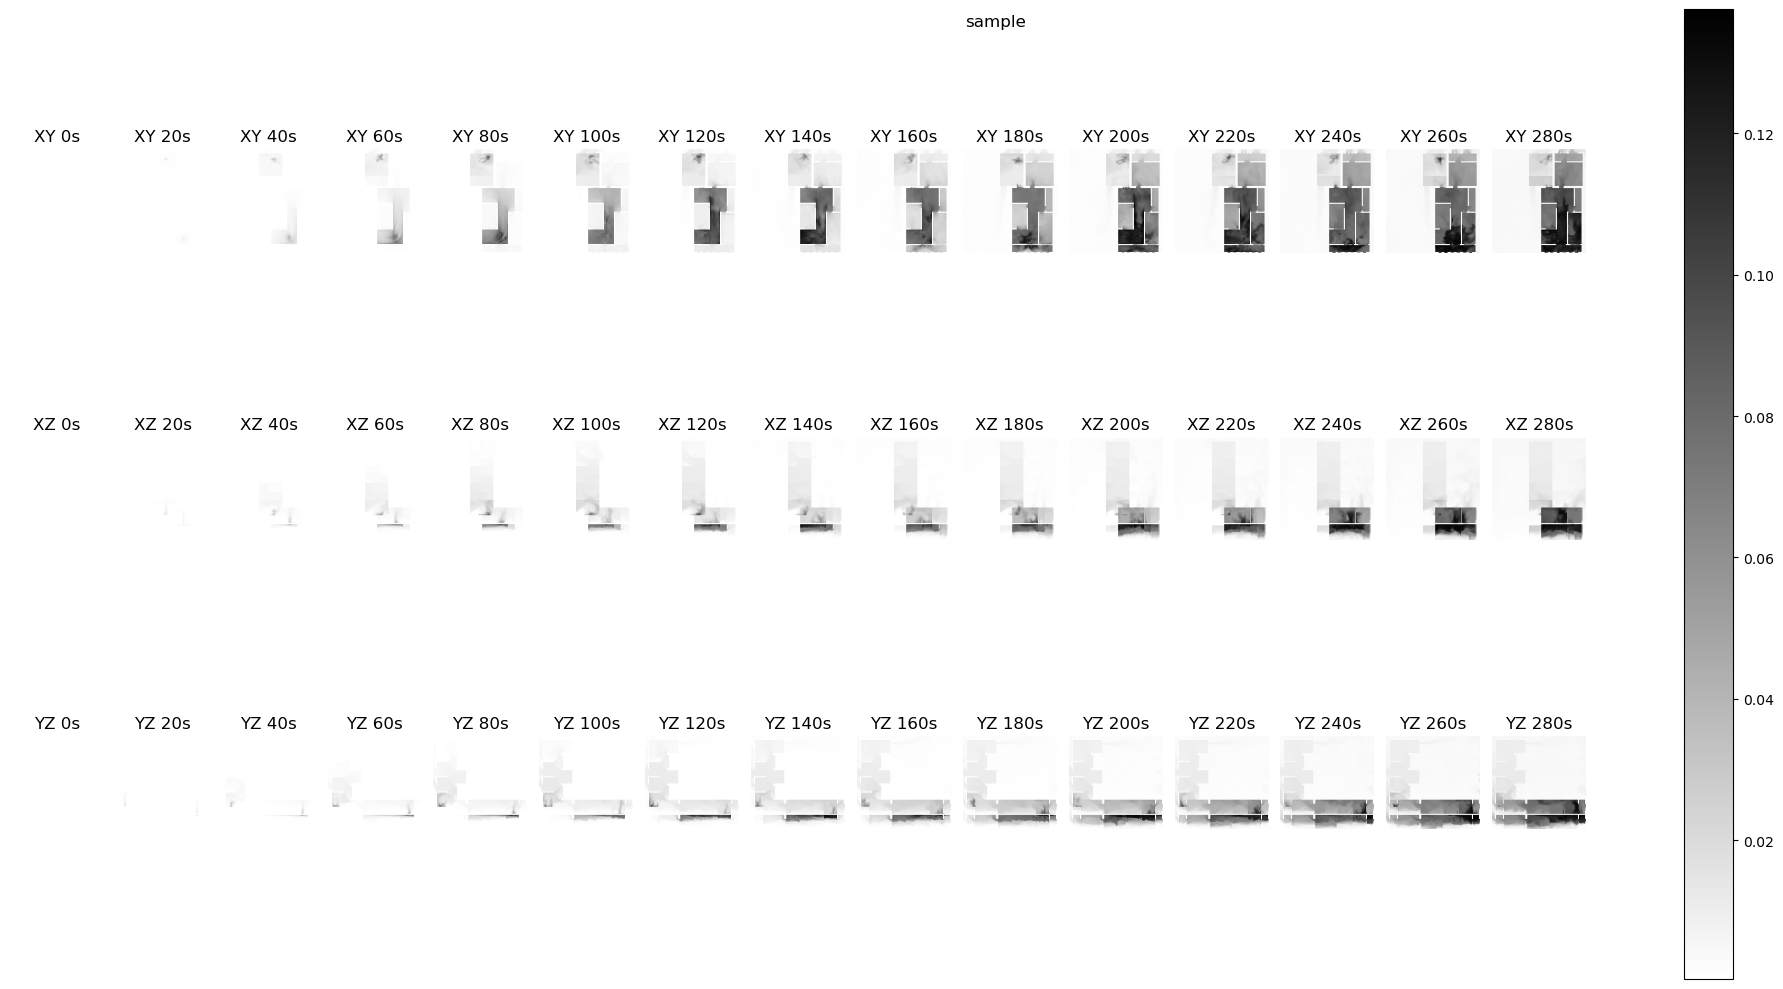

In [25]:
data_kind_idx = Place.MULTI.value
value_kind_idx = Particle.CO.value

data, time = data_load(data_kind_idx, value_kind_idx)
visual_3d(data)
visualize_slices_space(data, 299.9, time, title="sample", cmap='binary')
visualize_slices_time(data, time, title="sample", cmap='binary')

### Data Sampling